In [1]:
import os
from snorkel import SnorkelSession
session = SnorkelSession()

In [2]:
from snorkel.parser import TSVDocPreprocessor
    
doc_preprocessor = TSVDocPreprocessor('/users/anirudhmuthukumar/downloads/snorkel-master/myscripts/data/String RTT.tsv')

In [3]:
from snorkel.parser.spacy_parser import Spacy
from snorkel.parser import CorpusParser

corpus_parser = CorpusParser(parser=Spacy())
%time c = corpus_parser.apply(doc_preprocessor)

Clearing existing...
Running UDF...
CPU times: user 55 s, sys: 1.15 s, total: 56.2 s
Wall time: 57 s


In [4]:
from snorkel.models import Document, Sentence

print("Documents:", session.query(Document).count())
print("Sentences:", session.query(Sentence).count())

('Documents:', 26323)
('Sentences:', 26323)


## Splitting the dataset into three sets 

In [5]:
docs = session.query(Document).order_by(Document.name).all()

train_sents = set()
dev_sents   = set()
test_sents  = set()

for i, doc in enumerate(docs):
    for s in doc.sentences:
            if i % 10 == 8:
                dev_sents.add(s)
            elif i % 10 == 9:
                test_sents.add(s)
            else:
                train_sents.add(s)
                
len(dev_sents), len(train_sents), len(test_sents)

(2632, 21059, 2632)

Sample format of the sentences 

In [6]:
session.query(Sentence).all()

[Sentence(Document 1,0,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
 ),
 Sentence(Document 2,0,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
 ),
 Sentence(Document 3,0,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
 ),
 Sentence(Document 4,0,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

### Defining candidate subclass 
`Candidates` are basically potential mentions found in text in which we are interested in for training the model.

In [7]:
from snorkel.models import candidate_subclass

Person = candidate_subclass('Person', ['person'])
Number = candidate_subclass('RTT', ['number'])

In [11]:
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.matchers import RegexMatchEach

ngrams         = Ngrams(n_max=1)
number_matcher = RegexMatchEach(rgx='^[A]+$')
cand_extractor = CandidateExtractor(Number, [ngrams], [number_matcher])

### Applying `CandidateExtractor` to three sets of data

In [12]:
for i, sents in enumerate([train_sents, dev_sents, test_sents]):
    %time cand_extractor.apply(sents, split=i)
    print("Number of candidates:", session.query(Number).filter(Number.split == i).count())

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 23.9 s, sys: 416 ms, total: 24.3 s
Wall time: 24.5 s
('Number of candidates:', 21059)
Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 3.34 s, sys: 146 ms, total: 3.49 s
Wall time: 3.58 s
('Number of candidates:', 2632)
Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 3.27 s, sys: 130 ms, total: 3.4 s
Wall time: 3.49 s
('Number of candidates:', 2632)


In [13]:
train_cands = session.query(Number).filter(Number.split == 0).all()
dev_cands = session.query(Number).filter(Number.split == 1).all()
test_cands = session.query(Number).filter(Number.split == 2).all()

In [14]:
train_cands

[RTT(Span("AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA", sentence=38502, chars=[0,261], words=[0,0])),
 RTT(Span("AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA", sentence=42793, chars=[0,278], words=[0,0])),
 RTT(Span("AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA", sentence=34866, chars=[0,256], words=[0,0])),
 RTT(Span("AAAAAAAAAAA

## Defining labelling function 

In [41]:
def LF_Good_Measurement(c):
    string = ""
    for i in c.number.get_attrib_tokens():
        string+=i
    if len(string)<=283:
        return 1
    else:
        return 0

In [42]:
LFs = [ LF_Good_Measurement] 

In [43]:
labeled = []
for c in train_cands:
    if LF_Good_Measurement(c) != 0:
        labeled.append(c)
print("Total Candidates: ", len(train_cands))
print("Number labeled:", len(labeled))

('Total Candidates: ', 21059)
('Number labeled:', 16741)


In [44]:
from snorkel.viewer import SentenceNgramViewer

SentenceNgramViewer(dev_cands, session, n_per_page=1)

<IPython.core.display.Javascript object>

U2VudGVuY2VOZ3JhbVZpZXdlcihjaWRzPVtbWzczMF1dLCBbWzE2MzNdXSwgW1s3MjhdXSwgW1syNDU2XV0sIFtbMTg1Nl1dLCBbWzEzMjhdXSwgW1sxNjU2XV0sIFtbMTYwOF1dLCBbWzExMDfigKY=


In [49]:
ct = 1
for c in dev_cands:
   string = ""
   for i in c.number.get_attrib_tokens():
        string+=i 
   print str(ct), str(len(string))
   ct+=1

1 280
2 261
3 258
4 273
5 287
6 269
7 257
8 280
9 267
10 268
11 265
12 256
13 990
14 260
15 268
16 266
17 255
18 255
19 269
20 273
21 297
22 257
23 280
24 259
25 329
26 271
27 270
28 275
29 280
30 271
31 262
32 260
33 276
34 271
35 251
36 277
37 312
38 266
39 257
40 298
41 311
42 277
43 266
44 268
45 275
46 272
47 284
48 279
49 279
50 131
51 281
52 268
53 254
54 262
55 256
56 308
57 281
58 255
59 278
60 262
61 710
62 258
63 265
64 261
65 281
66 8470
67 279
68 290
69 272
70 256
71 258
72 262
73 273
74 280
75 285
76 261
77 131
78 258
79 676
80 289
81 281
82 260
83 271
84 272
85 263
86 272
87 259
88 275
89 256
90 276
91 256
92 265
93 284
94 287
95 271
96 279
97 289
98 263
99 287
100 263
101 1050
102 266
103 270
104 269
105 257
106 277
107 284
108 271
109 519
110 261
111 300
112 276
113 255
114 345
115 256
116 271
117 264
118 268
119 266
120 280
121 256
122 292
123 261
124 259
125 268
126 275
127 266
128 284
129 256
130 277
131 256
132 284
133 257
134 263
135 295
136 249
137 255
138 284
13

1281 281
1282 284
1283 261
1284 276
1285 133
1286 266
1287 278
1288 250
1289 263
1290 258
1291 270
1292 259
1293 262
1294 256
1295 276
1296 270
1297 257
1298 279
1299 269
1300 277
1301 269
1302 294
1303 267
1304 289
1305 259
1306 269
1307 297
1308 256
1309 280
1310 256
1311 269
1312 256
1313 272
1314 285
1315 278
1316 306
1317 280
1318 274
1319 284
1320 292
1321 277
1322 255
1323 259
1324 292
1325 274
1326 260
1327 282
1328 268
1329 258
1330 268
1331 267
1332 271
1333 255
1334 271
1335 267
1336 267
1337 267
1338 256
1339 274
1340 276
1341 267
1342 274
1343 274
1344 254
1345 270
1346 258
1347 285
1348 281
1349 264
1350 275
1351 267
1352 255
1353 258
1354 265
1355 258
1356 263
1357 265
1358 255
1359 274
1360 266
1361 279
1362 278
1363 265
1364 295
1365 274
1366 273
1367 281
1368 276
1369 287
1370 252
1371 255
1372 261
1373 273
1374 272
1375 294
1376 289
1377 284
1378 267
1379 277
1380 266
1381 259
1382 256
1383 268
1384 250
1385 259
1386 266
1387 267
1388 273
1389 252
1390 302
1391 289
1

2399 253
2400 318
2401 280
2402 289
2403 256
2404 257
2405 264
2406 277
2407 475
2408 278
2409 274
2410 303
2411 256
2412 272
2413 273
2414 271
2415 278
2416 287
2417 276
2418 243
2419 285
2420 297
2421 276
2422 282
2423 267
2424 134
2425 287
2426 269
2427 133
2428 292
2429 266
2430 274
2431 277
2432 282
2433 277
2434 254
2435 297
2436 256
2437 328
2438 271
2439 133
2440 255
2441 266
2442 646
2443 269
2444 266
2445 292
2446 133
2447 272
2448 269
2449 266
2450 275
2451 284
2452 257
2453 261
2454 274
2455 261
2456 243
2457 263
2458 276
2459 297
2460 284
2461 259
2462 289
2463 1117
2464 12728
2465 253
2466 272
2467 269
2468 268
2469 262
2470 269
2471 263
2472 280
2473 262
2474 282
2475 257
2476 268
2477 263
2478 277
2479 269
2480 259
2481 260
2482 271
2483 271
2484 263
2485 268
2486 284
2487 265
2488 261
2489 289
2490 267
2491 293
2492 287
2493 255
2494 263
2495 285
2496 301
2497 262
2498 281
2499 435
2500 268
2501 271
2502 281
2503 255
2504 272
2505 277
2506 268
2507 248
2508 275
2509 25

### Loading the annotated dev set 

In [50]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name=os.environ['USER'], split=1)
L_gold_dev

<2632x1 sparse matrix of type '<type 'numpy.int64'>'
	with 100 stored elements in Compressed Sparse Row format>

In [52]:
from snorkel.annotations import LabelAnnotator
import numpy as np

labeler = LabelAnnotator(lfs=LFs)

np.random.seed(1701)
%time L_train = labeler.apply(split=0)
L_train

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 1min 14s, sys: 1.5 s, total: 1min 15s
Wall time: 1min 19s


<21059x1 sparse matrix of type '<type 'numpy.int64'>'
	with 16741 stored elements in Compressed Sparse Row format>

In [53]:
L_train.lf_stats(session)

j  Coverage  Overlaps  Conflicts
LF_Good_Measurement  0  0.794957       0.0        0.0

In [54]:
L_train.get_candidate(session, 0)

RTT(Span("AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA", sentence=38502, chars=[0,261], words=[0,0]))

In [55]:
np.random.seed(1701)

%time L_dev = labeler.apply_existing(split=1, lfs=LFs, parallelism=1)
print L_dev.shape

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 8.71 s, sys: 92.5 ms, total: 8.81 s
Wall time: 8.88 s
(2632, 1)


In [56]:
L_dev.lf_stats(session, labels=L_gold_dev.toarray().ravel())

j  Coverage  Overlaps  Conflicts  TP  FP  FN  TN  \
LF_Good_Measurement  0  0.799012       0.0        0.0  69  15   0   0   

                     Empirical Acc.  
LF_Good_Measurement        0.821429

## Gen model 

In [58]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 2


In [59]:
gen_model.weights.lf_accuracy

array([1.09800709])

In [61]:
train_marginals = gen_model.marginals(L_train)
train_marginals

array([0.89989101, 0.89989101, 0.89989101, ..., 0.89989101, 0.5       ,
       0.89989101])

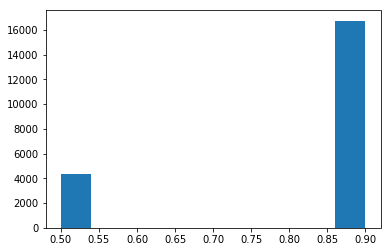

In [63]:
import matplotlib.pyplot as plt
plt.hist(train_marginals)
plt.show()

In [64]:
gen_model.learned_lf_stats()

Accuracy  Coverage  Precision    Recall
0   0.89473    0.7723   0.897289  0.689227

## Evaluating our model for dev set 

In [65]:
L_dev = labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



In [66]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.852
Neg. class accuracy: 0.203
Precision            0.0328
Recall               0.852
F1                   0.0632
----------------------------------------
TP: 69 | FP: 2034 | TN: 517 | FN: 12



Accuracy = (69+517) / ( 69+517+2034+12)
         = <b>22.26%<b>

## Investigating false positives 

In [67]:
SentenceNgramViewer(fp, session)

<IPython.core.display.Javascript object>

U2VudGVuY2VOZ3JhbVZpZXdlcihjaWRzPVtbWzE0OV0sIFsxOTY0XSwgWzI2NV1dLCBbWzYwOV0sIFsxMTEwXSwgWzE2MDFdXSwgW1sxMTM3XSwgWzQyNV0sIFs2NDBdXSwgW1sxNjcyXSwgWzHigKY=


## Naive Bayes Classifier 

In [69]:
from snorkelTG.learning import NaiveBayes

gen_model = NaiveBayes()
gen_model.train(L_train, n_iter=1000, rate=1e-5)

/Users/anirudhmuthukumar/Downloads/snorkel-master/snorkelTG/learning_utils.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/anaco

Training marginals (!= 0.5):	21059
Features:			1
Begin training for rate=1e-05, mu=1e-06
	Learning epoch = 0	Gradient mag. = 0.000000
SGD converged for mu=1e-06 after 10 steps


In [70]:
train_marginals = gen_model.marginals(L_train)

## Discriminative model 

In [71]:
from snorkelTG.learning import LogReg
from snorkelTG.learning_utils import RandomSearch, ListParameter, RangeParameter

iter_param = ListParameter('n_iter', [250, 500, 1000, 2000])
rate_param = RangeParameter('rate', 1e-4, 1e-2, step=0.75, log_base=10)
reg_param  = RangeParameter('mu', 1e-8, 1e-2, step=1, log_base=10)

disc_model = LogReg()

In [74]:
searcher = RandomSearch(disc_model, L_train, train_marginals, 10, iter_param, rate_param, reg_param)

In [75]:
np.random.seed(1701)
searcher.fit(L_dev, L_gold_dev, dev_cands)

Testing n_iter = 1.00e+03, rate = 1.00e-04, mu = 1.00e-02
Training marginals (!= 0.5):	16741
Features:			1
Using gradient descent...
	Learning epoch = 0	Step size = 0.0001
	Loss = 11603.976950	Gradient magnitude = 3868.102293
	Learning epoch = 100	Step size = 9.04792147114e-05
	Loss = 9750.684229	Gradient magnitude = 162.725199
	Learning epoch = 200	Step size = 8.18648829479e-05
	Loss = 9751.535488	Gradient magnitude = 179.486507
	Learning epoch = 300	Step size = 7.40707032156e-05
	Loss = 9752.566449	Gradient magnitude = 197.934712
	Learning epoch = 400	Step size = 6.70185906007e-05
	Loss = 9753.814015	Gradient magnitude = 218.231372
	Learning epoch = 500	Step size = 6.06378944861e-05
	Loss = 9755.322337	Gradient magnitude = 240.551851
	Learning epoch = 600	Step size = 5.48646907485e-05
	Loss = 9757.144139	Gradient magnitude = 265.086172
	Learning epoch = 700	Step size = 4.96411413431e-05
	Loss = 9759.342244	Gradient magnitude = 292.039850
	Learning epoch = 800	Step size = 4.4914914861

TypeError: get_candidate() takes exactly 3 arguments (2 given)

## Another Discriminative model

In [77]:
from snorkel.learning.disc_models.rnn import reRNN

train_kwargs = {
    'lr':         0.001,
    'dim':        100,
    'n_epochs':   10,
    'dropout':    0.25,
    'print_freq': 1,
    'batch_size': 128,
    'max_sentence_length': 100
}

lstm = reRNN(seed=1701, n_threads=1)
lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

IndexError: tuple index out of range